In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error


from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from numpy.lib.stride_tricks import sliding_window_view

from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer



# **Modelos de aprendizaje automático para estimar el uso de Bicing en una estación**

Este notebook contiene el código utilizado para el proyecto de APA ***Modelos de aprendizaje automático para estimar el uso
de Bicing en una estación*** realizado por **Nicolas Llorens** y **Fernando Guirao**. El informe que detalle todo el trabajo y conclusiones de este proyecto esta en `informe.pdf`.

## **Carga de los datos, adición de variables, filtro temporal, partición en train y test, tratamiento de missing values**

Cargamos los datos, añadimos variables y filtramos por tiempo.

In [ ]:
# Cargar el conjunto de datos
data = pd.read_csv('dataset.csv')

# Crear características 'lagged'
for i in range(1, 2):
    data[f'lag_{i}'] = data['exits'].shift(i)

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)
data = data.drop('demand_satisfied', axis=1)

# Crear una columna de fecha a partir de las columnas de año, mes y día
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-11-30')
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

data = data.drop('date', axis=1)

### **Estadísticas descriptivas**

In [ ]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hour,16776.0,11.500000,6.922393,0.0,5.75,11.5,17.250,23.0
day,16776.0,15.708155,8.789681,1.0,8.00,16.0,23.000,31.0
month,16776.0,6.283262,3.320801,1.0,3.00,6.0,9.000,12.0
year,16776.0,2022.477825,0.499523,2022.0,2022.00,2022.0,2023.000,2023.0
week_day,16776.0,2.998569,2.001132,0.0,1.00,3.0,5.000,6.0
working_day,16776.0,0.682403,0.465555,0.0,0.00,1.0,1.000,1.0
class_day,16776.0,2.190272,0.929357,1.0,1.00,3.0,3.000,3.0
exits,16776.0,2.609859,3.990074,0.0,0.00,1.0,3.000,42.0
temperature,16776.0,17.492096,7.204220,-1.6,12.00,17.7,23.025,36.8
a_temperature,16776.0,17.231313,9.155843,-6.1,10.00,17.3,24.800,40.3


### **Distribución de las variables**

Obviamos las variables que hemos creado ya que estas son para ayudar al modelo o el filtrado, pero al ser hecha a partir de otras variables de nuestro dataset no son relevantes de graficar concretamente.

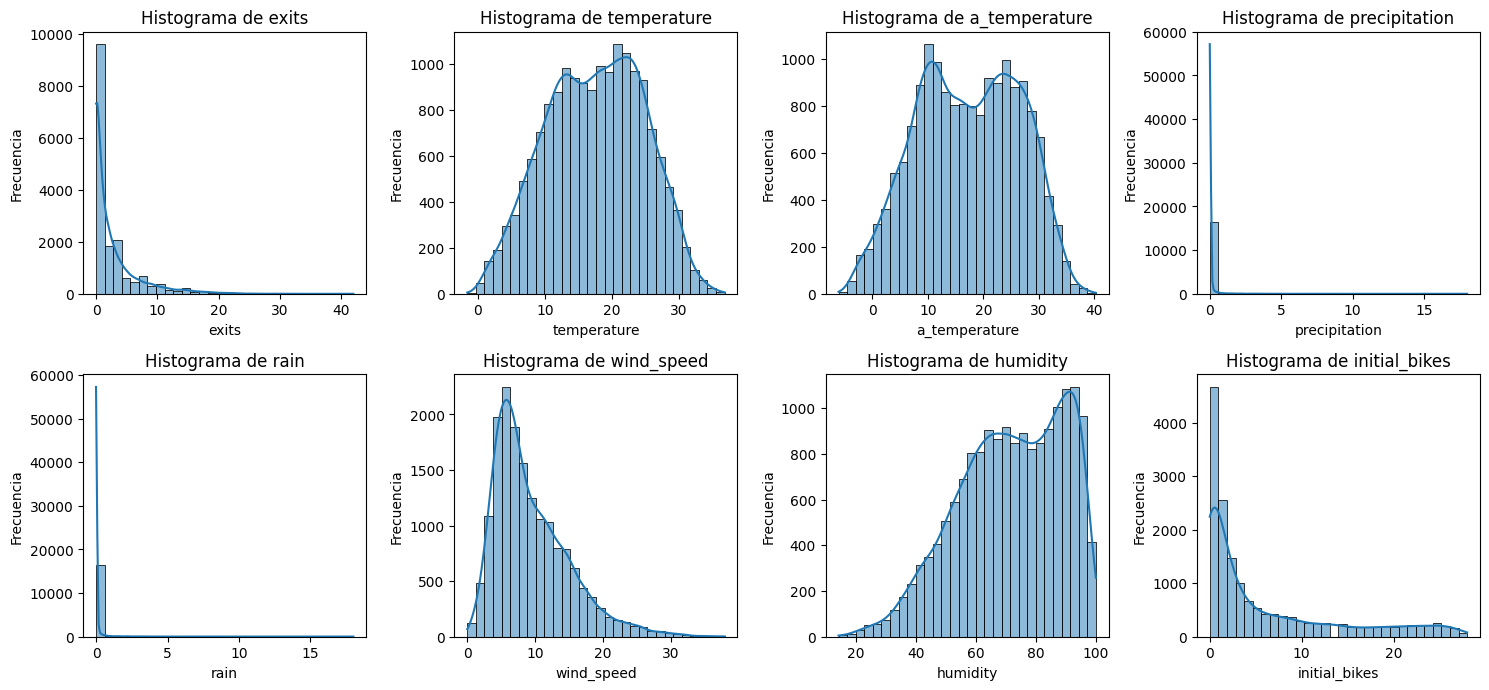

In [ ]:
# Lista de variables numéricas
numeric_vars = ["exits", "temperature", "a_temperature", "precipitation", "rain", "wind_speed", "humidity","initial_bikes"]
#No graficamos ni lag_1 ni demand_satisfied_lag

# Visualización de histogramas para las variables numéricas
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Histograma de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show();

Como vemos, rain y precipitation son casi lo mismo. Por lo que nos quedaremos tan solo con precipitation.

In [ ]:
data.drop('rain', axis=1, inplace=True)


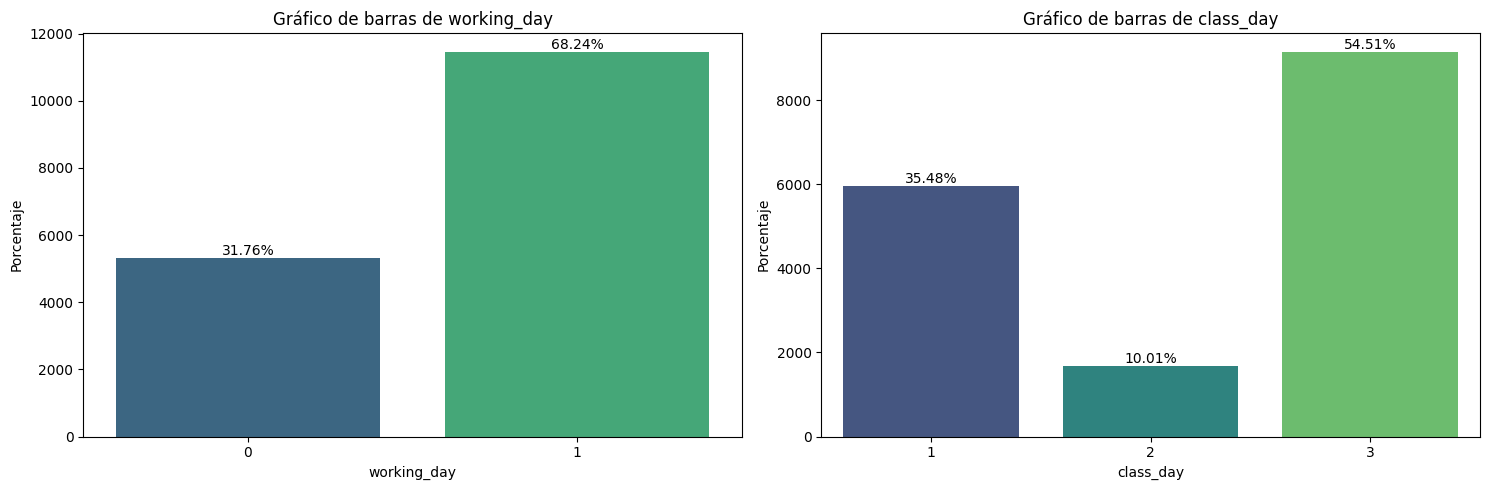

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Defining the list of categorical variables
categorical_vars = ['working_day', 'class_day']

# Plotting bar charts for categorical variables with percentages
plt.figure(figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    plt.subplot(1, 2, i+1)
    sns.countplot(x=var, data=data, palette='viridis')
    plt.title(f'Gráfico de barras de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje')

    # Calculate the percentages and display them on the bars
    total = len(data[var])  # Total number of records for normalization
    for p in plt.gca().patches:
        height = p.get_height()  # Get the height of each bar
        # Put the annotation on the bar
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}%'.format((height / total) * 100),
                       ha="center", va='bottom')

plt.tight_layout()
plt.show();


### **Realción de la variable objetivo con el resto de variables**

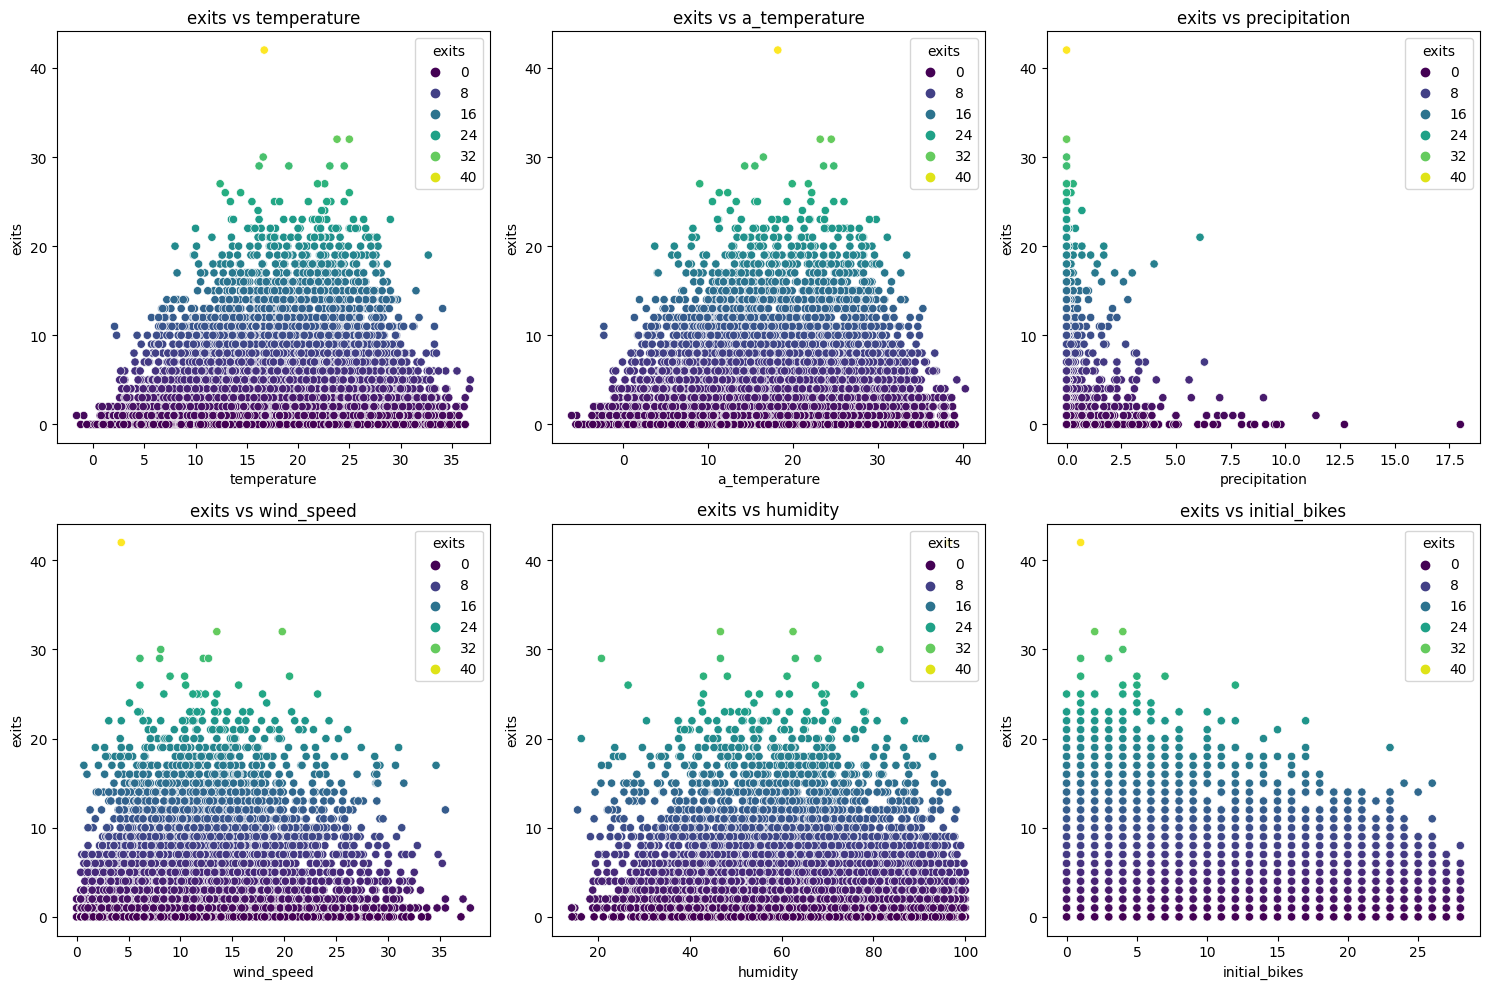

In [ ]:
numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity","initial_bikes"]

# Gráficos de dispersión para variables numéricas
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars_without_exits, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=data, x=var, y="exits", hue='exits', palette="viridis")
    plt.title(f'exits vs {var}')

plt.tight_layout()
plt.show();

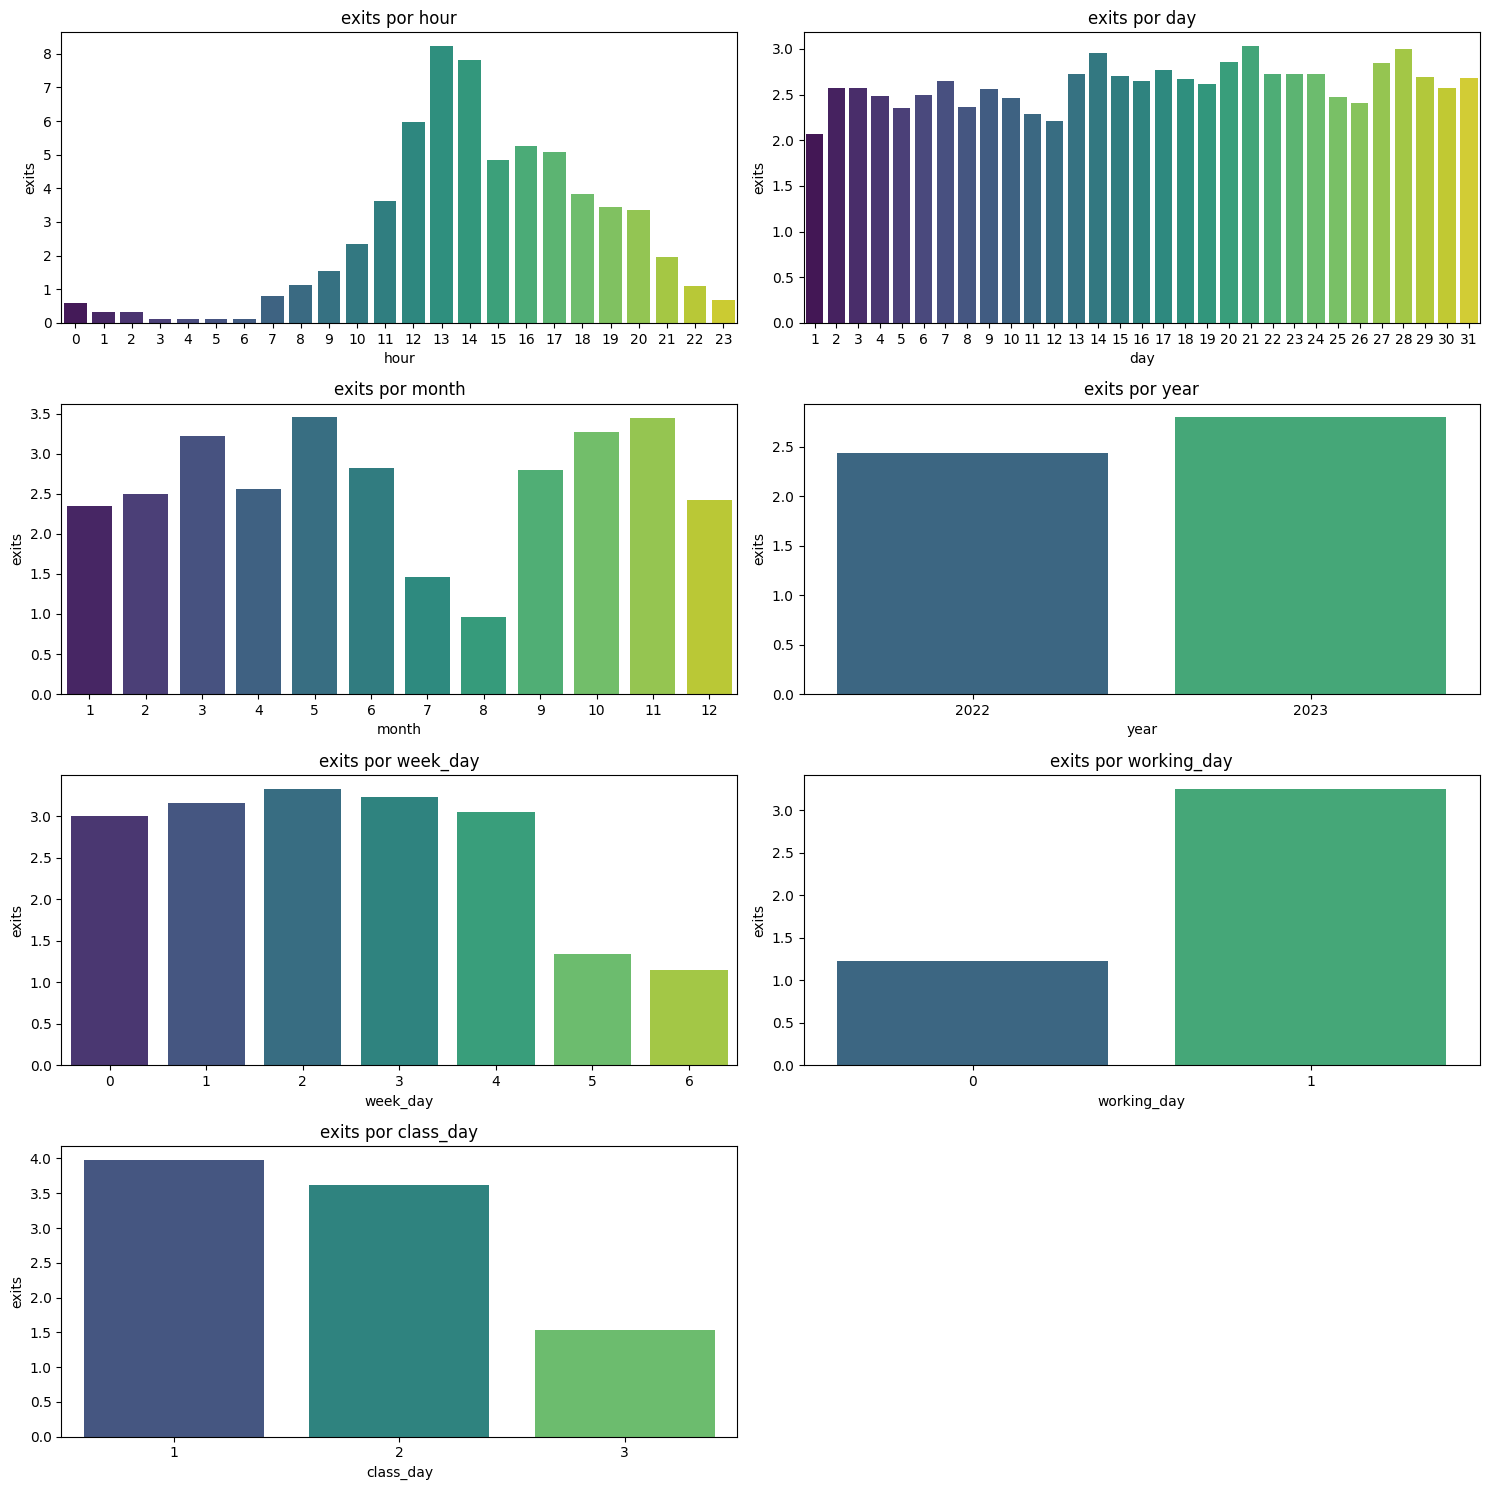

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day"]

plt.figure(figsize=(15, 15))
for i, var in enumerate(categorical_vars_selected, 1):
    plt.subplot(4, 2, i)
    sns.barplot(data=data, x=var, y="exits", errorbar=None, palette="viridis")
    plt.title(f'exits por {var}')

plt.tight_layout()
plt.show();

<Axes: >

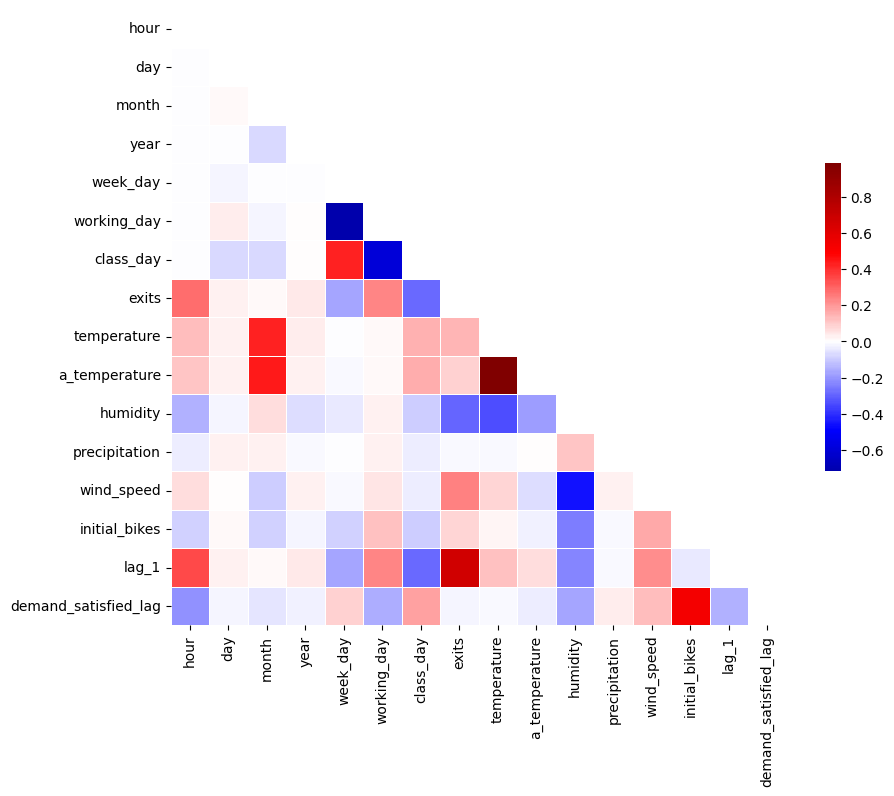

In [ ]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Partimos en train y test.

In [ ]:
from sklearn.model_selection import train_test_split

split_index = int(len(data) - 24)

# Divide los datos en conjuntos de entrenamiento y prueba según el índice calculado
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# data_train, data_test = train_test_split(data, test_size=0.1, shuffle=False)

data_train.shape, data_test.shape

((16752, 17), (24, 17))

Localizamos missing values

In [ ]:
data_train.isna().sum()

hour                      0
day                       0
month                     0
year                      0
week_day                  0
working_day               0
class_day                 0
exits                     0
temperature               0
a_temperature             0
humidity                  0
precipitation             0
rain                      0
wind_speed                0
initial_bikes           653
lag_1                     0
demand_satisfied_lag    653
dtype: int64

Imputar valores perdidos en el conjunto de entrenamiento.

In [ ]:
from sklearn.impute import KNNImputer
data_imputer = data_train.drop('exits', axis=1)

knni_demand_satisfied_lag = KNNImputer(n_neighbors=10)
knni_initial_bikes = KNNImputer(n_neighbors=10)

i_demand_satisfied_lag = knni_demand_satisfied_lag.fit_transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.fit_transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
data_train['initial_bikes'] = i_initial_bikes

<ipython-input-296-dab25ab3a451>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-296-dab25ab3a451>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['initial_bikes'] = i_initial_bikes


In [ ]:
data_train.isna().sum()

hour                    0
day                     0
month                   0
year                    0
week_day                0
working_day             0
class_day               0
exits                   0
temperature             0
a_temperature           0
humidity                0
precipitation           0
rain                    0
wind_speed              0
initial_bikes           0
lag_1                   0
demand_satisfied_lag    0
dtype: int64

Imputamos valores perdidos en el conjunto de test utilizando el modelo entrenado con los datos de entrenamiento.

In [ ]:
data_test.isna().sum()

hour                    0
day                     0
month                   0
year                    0
week_day                0
working_day             0
class_day               0
exits                   0
temperature             0
a_temperature           0
humidity                0
precipitation           0
rain                    0
wind_speed              0
initial_bikes           0
lag_1                   0
demand_satisfied_lag    0
dtype: int64

In [ ]:
data_imputer = data_test.drop('exits', axis=1)

i_demand_satisfied_lag = knni_demand_satisfied_lag.transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
data_test['initial_bikes'] = i_initial_bikes

<ipython-input-299-39500e2f055e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-299-39500e2f055e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['initial_bikes'] = i_initial_bikes


In [ ]:
data_test.isna().sum()

hour                    0
day                     0
month                   0
year                    0
week_day                0
working_day             0
class_day               0
exits                   0
temperature             0
a_temperature           0
humidity                0
precipitation           0
rain                    0
wind_speed              0
initial_bikes           0
lag_1                   0
demand_satisfied_lag    0
dtype: int64